###[ENPM673 PROJECT 2]
By: Kashif Ansari (120278280)

###Problem statement 1

>> Connecting google drive with google colab and Importing necessary libraries

In [31]:
#Connecting google drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [1]:
# Change the working directory
path_to_folder = "ENPM673/tutorials"
%cd /content/drive/My\ Drive/{path_to_folder}

/content/drive/My Drive/ENPM673/tutorials


In [2]:
#Importing the required libraries
import cv2
import os
from scipy.ndimage import variance as var
from matplotlib import pyplot as plt
from google.colab import drive
from google.colab.patches import cv2_imshow
from IPython.display import clear_output
import numpy as np
from IPython.display import clear_output


>>Reading the given video and extracting individual frames from it

In [27]:
#Problem statement1
#Read a video
video_capture = cv2.VideoCapture('assets/proj2_v2.mp4')

# Get video properties
frame_width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(video_capture.get(cv2.CAP_PROP_FPS))

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('corner_detection.mp4', fourcc, 30.0, (frame_width, frame_height), 0)

#Loop to return the frame captured
blurry_frame = 0
sharp_frame = 0
line_length = 0.5 * max(frame_width, frame_height) # This has been used below in Hough Transform


The provided code snippet demonstrates an image processing pipeline designed for real-time video processing. Here's a breakdown of the steps involved:

1. **Video Capture**: The pipeline starts by capturing frames from a video source continuously using `video_capture.read()` in a loop.

2. **Frame Preprocessing**:
   - Each frame is converted to grayscale using `cv2.cvtColor()` to simplify subsequent processing.
   
3. **Blur Detection**:
   - The Laplacian operator is applied to detect the presence of blur in the frame. If the variance of the Laplacian is below a certain threshold, the frame is considered blurry and skipped.

4. **Edge Detection**:
   - Canny edge detection is performed on the grayscale frame to identify prominent edges.

5. **Line Detection**:
   - The Hough Transform is applied to detect straight lines in the edge-detected frame.

6. **Corner Detection**:
   - Intersections of the detected lines are computed to identify corners. Harris corner detection is also utilized to refine the corner detection process.

7. **Filtering and Verification**:
   - Detected corners are filtered based on a threshold to eliminate extraneous points.
   - Common corners between the initial corner detection and the filtered set are identified.




In [28]:
while True:
    ret, frame = video_capture.read()
    if not ret:
        break

    # frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Calculate Variance of the Laplacian
    # laplacian_var = var(cv2.Laplacian(frame_gray, cv2.CV_64F))
    # Calculate Laplacian manually
    laplacian_kernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
    laplacian_frame = cv2.filter2D(frame_gray, cv2.CV_64F, laplacian_kernel)

    # Calculate the variance of the Laplacian
    laplacian_var = np.var(laplacian_frame)

    # Check if frame is blurry
    if laplacian_var < 150:
        blurry_frame += 1
        continue  # Skip processing blurry frames

    frame_edge = cv2.Canny(frame_gray, 600, 800)
    sharp_frame +=1

    # Perform Hough Transform to extract straight lines
    lines = cv2.HoughLinesP(frame_edge, rho=1, theta=1*np.pi/180, threshold=90, minLineLength = 30, maxLineGap=20)

    # Draw lines on the original frame
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)


    # Find intersections of the lines to compute corners
    corners = []
    if lines is not None:
        for i in range(len(lines)):
            for j in range(i+1, len(lines)):
                line1 = lines[i][0]
                line2 = lines[j][0]
                x1, y1, x2, y2 = line1
                x3, y3, x4, y4 = line2
                denominator = ((x1 - x2) * (y3 - y4)) - ((y1 - y2) * (x3 - x4))
                if denominator != 0:
                    px = (((x1 * y2 - y1 * x2) * (x3 - x4)) - ((x1 - x2) * (x3 * y4 - y3 * x4))) / denominator
                    py = (((x1 * y2 - y1 * x2) * (y3 - y4)) - ((y1 - y2) * (x3 * y4 - y3 * x4))) / denominator
                    corners.append((int(px), int(py)))

    # Convert corners to integer coordinates
    corners = np.int32(np.round(corners))

    # Draw red circles at detected corners
    for corner in corners:
        x, y = corner
        cv2.circle(frame, (x, y), 5, (0, 0, 255), -1)


    # Verify corners using Harris corner detector
    gray = np.float32(frame_gray)
    harris_corners = cv2.cornerHarris(gray, 7, 5, 0.04)

    # Threshold to obtain binary image of corners
    threshold = 5
    corner_threshold = harris_corners > threshold

    # Filter out extraneous corners
    filtered_corners = []
    for corner, response in zip(corners, corner_threshold):
        x, y = corner.ravel()
        if response.any():
            filtered_corners.append((x, y))

    # # Draw red circles at detected corners
    # for corner in filtered_corners:
    #     x, y = corner
    #     cv2.circle(frame, (x, y), 5, (0, 0, 255), -1)

    # Find common corners
    common_corners = []
    for corner in corners:
        for filtered_corner in filtered_corners:
            if np.all(corner == filtered_corner):
                common_corners.append(corner)
                break

    # # Draw red circles at detected corners
    # for corner in common_corners:
    #     x, y = corner
    #     cv2.circle(frame, (x, y), 5, (0, 0, 255), -1)



    # Display the frame with detected corners
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
    plt.show()
    out.write(frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    # cv2_imshow(frame)
    out.write(frame)
    clear_output(wait=True) # Clear the output cell to update the frame

print("total blurry frames skipped", blurry_frame)
print("total sharp frames frames displayed", sharp_frame)



# Release VideoCapture and VideoWriter objects
video_capture.release()
out.release()

total blurry frames skipped 248
total sharp frames frames displayed 138


>> Skipping blurry frames using Variance of the Laplacian: threshold = 150 and Segmenting out the unwanted background area.

###Problem Statement 2
Stitching images for panaromic effect

>> Reading and displaying the image

Given images



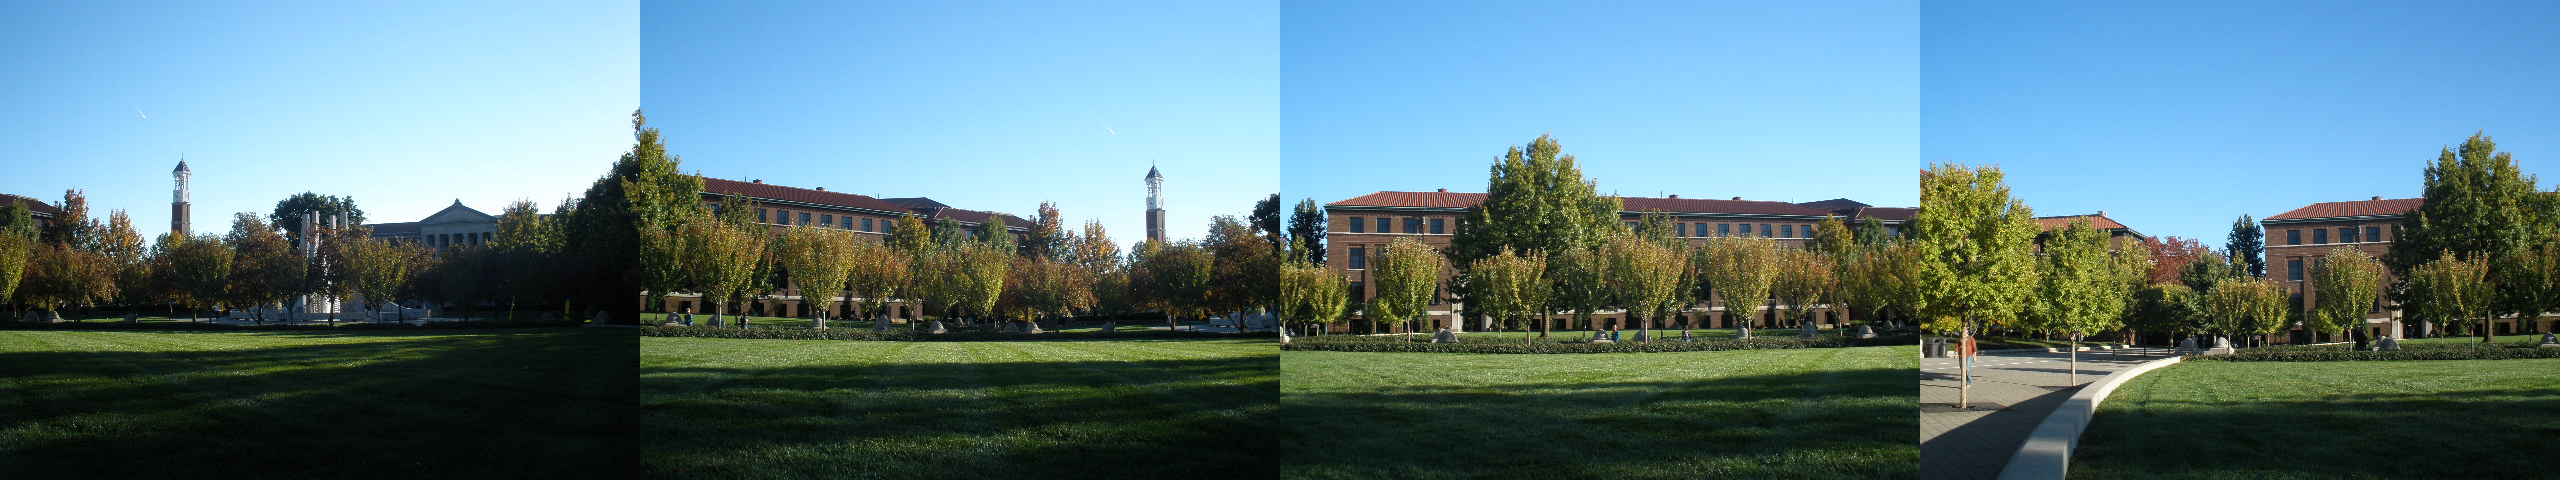

In [44]:
image_path1 =  cv2.imread("assets/PA120272.JPG")
image_path2 = cv2.imread("assets/PA120273.JPG")
image_path3 = cv2.imread("assets/PA120274.JPG")
image_path4 = cv2.imread("assets/PA120275.JPG")

images_row = cv2.hconcat([image_path1, image_path2, image_path3, image_path4])

# Display the concatenated image
print("Given images""\n")
cv2_imshow(images_row)



>Extracting the feature from each frame and displaying the blobs. Here to demonstrate the code in action images PA120272 and PA120273 as a sample has been used.

>> The Scale-Invariant Feature Transform (SIFT) is the algorithm used here which provides several advantages over other feature extractors. Firstly, it offers scale invariance, meaning it can detect and describe features regardless of their size, making it robust to changes in scale. Additionally, SIFT features are rotation invariant, enabling accurate detection and description of features even if objects are rotated within an image. Moreover, SIFT features are highly distinctive, facilitating reliable differentiation between keypoints in an image. Their localization property allows precise detection of keypoints in cluttered scenes, while their robustness to illumination changes and noise further enhances their utility in various environments. Despite being computationally intensive, SIFT is efficient and optimized, making it practical for real-time or near real-time applications in computer vision.


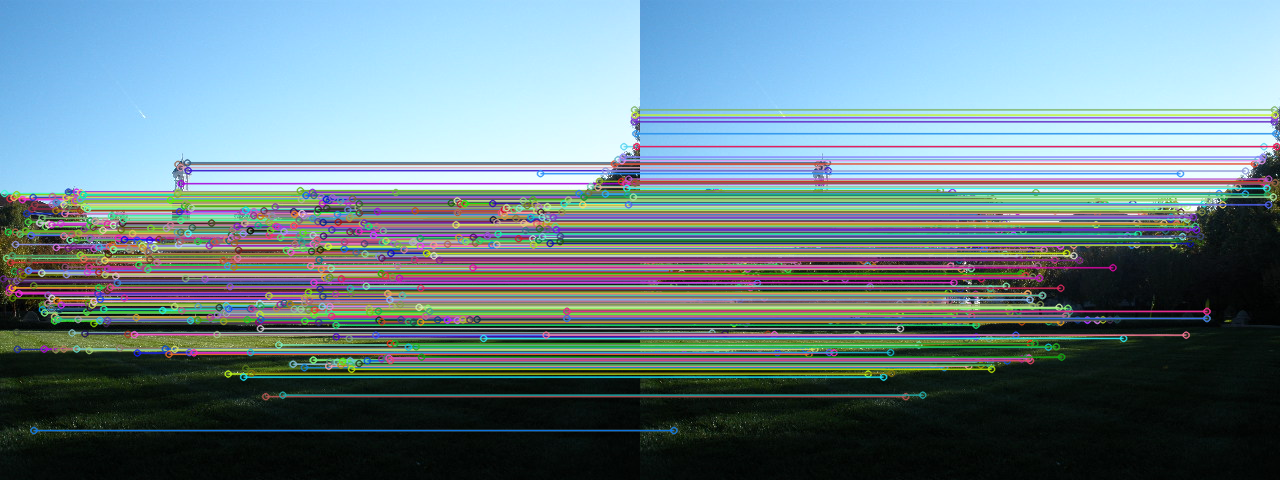

In [45]:
gray1 = cv2.cvtColor(image_path1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image_path1, cv2.COLOR_BGR2GRAY)

#Use of sift detecter
sift = cv2.SIFT_create()
keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

# Initialize the BFMatcher
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

#filtering matches
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)
# Draw matches
img_matches = cv2.drawMatches(image_path1, keypoints1, image_path1, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
cv2_imshow(img_matches)




In [41]:
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
homography, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
print("Homography obtained from image1 and image2 \n" )
print(homography)

Homography obtained from image1 and image2 

[[ 1.00000000e+00 -2.44234649e-15  1.30196348e-12]
 [-2.37497873e-15  1.00000000e+00  1.51738655e-12]
 [-9.45094350e-18 -1.10655080e-17  1.00000000e+00]]


In [ ]:

def image_stitcher(img1, img2):

    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)


    # Initialize the BFMatcher
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    # Filter matches based on distance ratio
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # Draw matches
    img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)


    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    homography, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # Warp the image onto the base image using the homography
    height_base, width_base = img1.shape[:2]
    height_img, width_img = img2.shape[:2]
    width_combined = width_base + width_img
    warped_img = cv2.warpPerspective(img1, homography, (width_combined, height_base))
    warped_img[0:height_img, 0:width_img] = img2

    return warped_img


>>Finally combining the panaromic images together




Final result after stitching 



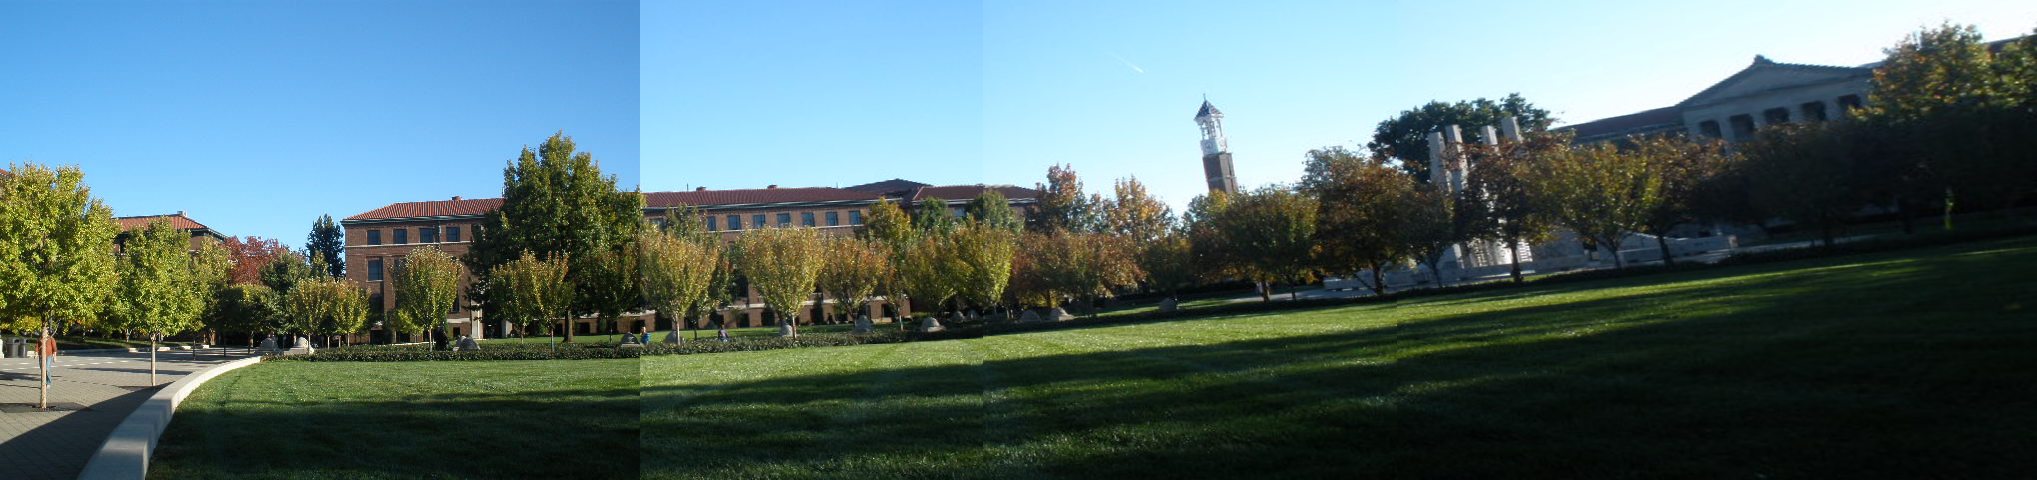

In [43]:
# Stitching images together
stitched_34 = image_stitcher(image_path3,image_path4)

# Obtains the black pixel by traversing the first row to crop image in a better way
gray_stitch = cv2.cvtColor(stitched_34, cv2.COLOR_BGR2GRAY)
for i in range(len(gray_stitch[0])):
        min_black_pixels = gray_stitch[0][i]
        if min_black_pixels == 0:
            min_black_pixels = i-1
            break

# Cropped image till the first black pixel obtained
cropped_image1 = stitched_34[:, :min_black_pixels]

# # Stitching images together
stitched_234 = image_stitcher(image_path2, cropped_image1)

# # Obtains the black pixel by traversing the first :row to crop image in a better way
gray_stitch = cv2.cvtColor(stitched_234, cv2.COLOR_BGR2GRAY)
for i in range(len(gray_stitch[0])):
        min_black_pixels = gray_stitch[0][i]
        if min_black_pixels == 0:
            min_black_pixels = i-1
            break

# # Cropped image till the first black pixel obtained
cropped_image2 = stitched_234[:, :min_black_pixels]

# # Stitching all the images together
print("Final result after stitching \n")
stiched_1234 = image_stitcher(image_path1, cropped_image2)

cv2_imshow(stiched_1234)

cv2.destroyAllWindows()

###Question B
Q. In general, why does panoramic mosaicing work better when the camera is only allowed to rotate at its camera
center?

Panoramic mosaicing, the process of stitching multiple images together to create a seamless panorama, benefits from restricting the camera to rotate at its optical center for several reasons. Below are some resons listed: -


-----------------------------------------------------------------------------

1. **Reduced Parallax Error:** When rotating the camera around its optical center, the parallax effect is minimized because the relative positions of objects in the scene remain more consistent across images. This results in better alignment during the stitching process.

2. **Simplified Homography Estimation:** Homography becomes simpler when the camera rotates around its optical center. Homography relates corresponding points in different images, and assuming the camera rotates about its optical center reduces the complexity of estimating the homography matrix.

3. **Easier Image Registration:** Rotating the camera about its optical center simplifies the process of registering images (aligning them properly) before stitching.

4. **Minimized Distortion Effects:** Also rotating the camera at its optical center helps minimize distortion effects, particularly those caused by changes in perspective. Distortion can affect the accuracy of image registration and the quality of the final panorama. By rotating the camera at its optical center, distortions are minimized. etc.

--------------------------------------------------------------------------